# 1-D Time Series Anomaly Detection

Our data set contains the mean, max, and min daily temperatures over Metro Manila from Jan. 1, 2020 to Apr. 30, 2024 

In [8]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

df = pd.read_csv('metro_manila_temp.csv')
df.head()

,year,day_of_year,T2M,T2M_MAX,T2M_MIN
0,2020,1,26.51,29.56,24.39
1,2020,2,26.43,29.48,24.49
2,2020,3,25.62,28.68,23.64
3,2020,4,25.37,29.08,22.71
4,2020,5,25.10,28.21,22.98


In [2]:
df["Date"] =  pd.to_datetime(df['year'].astype(str) + df['day_of_year'].astype(str), format='%Y%j')
df.head()

,year,day_of_year,T2M,T2M_MAX,T2M_MIN,Date
0,2020,1,26.51,29.56,24.39,2020-01-01
1,2020,2,26.43,29.48,24.49,2020-01-02
2,2020,3,25.62,28.68,23.64,2020-01-03
3,2020,4,25.37,29.08,22.71,2020-01-04
4,2020,5,25.10,28.21,22.98,2020-01-05


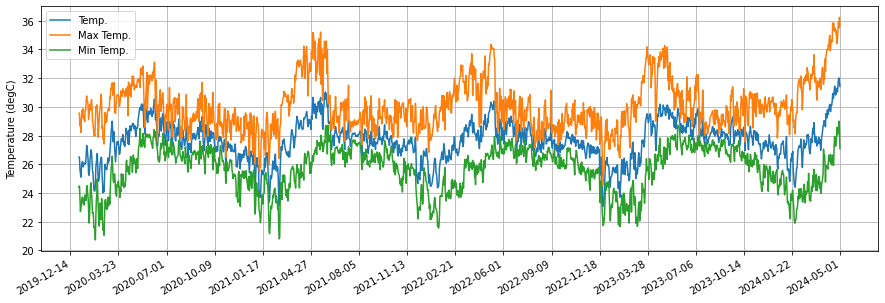

In [3]:
dates = df["Date"].to_numpy()

plt.figure(figsize=(15,5))
plt.plot(dates, df["T2M"].to_numpy(), label='Temp.')
plt.plot(dates, df["T2M_MAX"].to_numpy(), label='Max Temp.')
plt.plot(dates, df["T2M_MIN"].to_numpy(), label='Min Temp.')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.ylabel('Temperature (degC)')
plt.legend()
plt.grid()
plt.show()

## Apply KDE on the Max Temp. Data
First, create the KDE class

In [4]:
class my_kde:        
    def fit_1d(self, X, h=None):
        self.X = X
        x_lo = np.min(X) - 0.5*(np.max(X) - np.min(X))
        x_hi = np.max(X) + 0.5*(np.max(X) - np.min(X))
        x_fine = np.linspace(x_lo, x_hi, 150)
        y_fine = np.zeros(x_fine.shape)

        self.n = len(X)
        
        if h == None:
            self.h = np.std(X) * (4/3/self.n) ** 0.2   # Silverman's rule
        else:
            self.h = h

        for i in range(len(x_fine)):
            y_fine[i] = np.sum(np.exp(-(((X - x_fine[i]) / self.h) ** 2))) / self.n / self.h

        return x_fine, y_fine
    
    def score(self, x):
        return np.sum(np.exp(-(((self.X - x) / self.h) ** 2))) / self.n / self.h

Split the data into training (2020 to 2022) and testing (2023-2024)

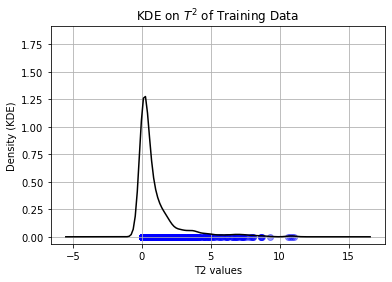

In [5]:
x = df["T2M_MAX"].to_numpy()

x_train = x[df["year"] <= 2022].reshape(-1,1)
x_test = x[df["year"] > 2022].reshape(-1,1)
date_train = df.loc[df["year"] <= 2022, "Date"].to_numpy()
date_test = df.loc[df["year"] > 2022, "Date"].to_numpy()

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

# Hotelling T2 statistic
T2 = x_train_scaled ** 2

kde = my_kde()
x_fine, y_fine = kde.fit_1d(T2)
plt.plot(x_fine, y_fine, c='k')
plt.scatter(T2, np.zeros(T2.shape), c='b', alpha=0.4)
plt.ylim(top = np.max(y_fine)*1.5)
plt.xlabel('T2 values')
plt.ylabel('Density (KDE)')
plt.title('KDE on $T^2$ of Training Data')
plt.grid()
plt.show()

## Calculate the detection limit at 99% confidence level

In [6]:
conf = 0.99

pos = x_fine > 0
y_fine = y_fine[pos]
x_fine = x_fine[pos]
    
# Use numerical integration to find the area under the KDE curve
A = np.cumsum(np.hstack((0, np.diff(x_fine, axis=0))) * y_fine)

# Set the threshold at conf-% of the area 
thresh = np.max(x_fine[A <= conf*A[-1]])

print(f"KDE threshold on T2: {thresh}")
anomalies_train = (T2 > thresh).ravel()
anomalies_test = (x_test_scaled ** 2 > thresh).ravel()

print('Actual thresholds in temperature (degC):')
UCL = sc.inverse_transform(np.sqrt(thresh).reshape(-1,1))
LCL = sc.inverse_transform(-np.sqrt(thresh).reshape(-1,1))
print(f"  Upper control limit: {UCL}")
print(f"  Lower control limit: {LCL}")

KDE threshold on T2: 8.41315111548197
Actual thresholds in temperature (degC):
  Upper control limit: [[34.52577133]]
  Lower control limit: [[25.13760458]]


## Plot the control chart

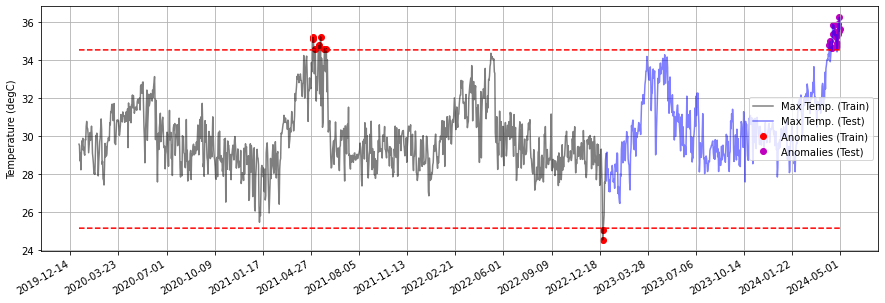

In [7]:
plt.figure(figsize=(15,5))
plt.plot(date_train, x_train, c='k', alpha=0.5, label='Max Temp. (Train)')
plt.plot(date_test, x_test, c='b', alpha=0.5, label='Max Temp. (Test)')
plt.scatter(date_train[anomalies_train], x_train[anomalies_train], c='r', label='Anomalies (Train)')
plt.scatter(date_test[anomalies_test], x_test[anomalies_test], c='m', label='Anomalies (Test)')

plt.plot(df["Date"].to_numpy(), (UCL*np.ones(len(df))).ravel(), "r--")
plt.plot(df["Date"].to_numpy(), (LCL*np.ones(len(df))).ravel(), "r--")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.ylabel('Temperature (degC)')
plt.legend()
plt.grid()
plt.show()